Currently, we observe that EB-CB does not achieve the correct marginal coverage using the noisy prior. My goal now is to isolate the problem. Is it
1. The estimated posterior score distribution is too inaccurate now that I’ve replaced the oracle prior with the noisy prior, AND/OR
2. I am taking the incorrect quantile of the posterior score distributions when performing the conformal adjustment?
I strongly suspect that it is 1
Supporting evidence: Using the oracle prior, it does not matter whether I perform the conformal adjustment using n=1 datapoints or n=10 datapoints 
n=10: 0.88828 
n=1: 0.89453125
Since the quantiles are similar, the resulting coverage metrics are similar too
But, to test my hunch, I can create a plot of the marginal coverage that results for each quantile between 80% and 99% (using 1% increments). This is what I do in Section 1

Most of this code is extracted from `pipeline.ipynb`

# Section 1

## Load data

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch

from scipy import stats
from scipy.stats import beta

from conformal_utils import *
from fit_betas import beta_MoM, beta_variance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [3]:
%%time

scores_all = 1 - softmax_scores

CPU times: user 844 ms, sys: 1min 10s, total: 1min 11s
Wall time: 1min 12s


In [4]:
alpha = .1
n_k = 20 
n_k_tune = 1
num_samples = 10000 # Number of Monte Carlo samples for estimating quantile of posterior score distribution
num_classes = 1000 # Number of classes in ImageNet

In [5]:
%%time

# Split into calibration data and validation data
calib_scores_all, calib_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_k + n_k_tune, num_classes=1000, seed=0)

# Split calibration into
#   1. Data to use for estimating D
#   2. Data to use for computing conformal adjustment
scores1_all, labels1, scores2_all, labels2 = split_X_and_y(calib_scores_all, calib_labels, n_k, num_classes=1000, seed=0)

CPU times: user 3.94 s, sys: 1min 35s, total: 1min 39s
Wall time: 1min 41s


## Compute marginal coverage for different quantiles

NOTE: We are trying to compute "ground truth" coverage, so I use the full validation set

In [6]:
cached_samples = np.load('.cache/cached_samples_pipeline.npy')

In [37]:
quantiles = np.arange(0.8, 1, 0.01)
marginal_cov = np.zeros(quantiles.shape)
avg_set_size = np.zeros(quantiles.shape)

print('Quantile guess || Ground truth marginal coverage || Average set size' )
print('--------------------------------------------------------------------')
for i,quantile_guess in enumerate(quantiles):
    
    # 1. Get qhats
    qhats = [np.quantile(cached_samples[k,:], quantile_guess, interpolation='higher') for k in range(num_classes)]

    # 2. Compute coverage using these qhats
#     preds = create_cb_prediction_sets(scores2_all, qhats)
#     marginal_cov[i] = compute_coverage(labels2, preds)
    preds = create_cb_prediction_sets(val_scores_all, qhats)
    marginal_cov[i] = compute_coverage(val_labels, preds)
    avg_set_size[i] = compute_avg_set_size(preds)
    print(f"{quantile_guess:>14.3f} || {marginal_cov[i]:>30.4f} || {avg_set_size[i]:>16.2f}")
    


Quantile guess || Ground truth marginal coverage || Average set size
--------------------------------------------------------------------
         0.800 ||                         0.8585 ||             3.32
         0.810 ||                         0.8684 ||             3.96
         0.820 ||                         0.8781 ||             4.79
         0.830 ||                         0.8874 ||             5.87
         0.840 ||                         0.8965 ||             7.35
         0.850 ||                         0.9052 ||             9.39
         0.860 ||                         0.9137 ||            12.07
         0.870 ||                         0.9221 ||            15.63
         0.880 ||                         0.9303 ||            20.44
         0.890 ||                         0.9381 ||            26.92
         0.900 ||                         0.9457 ||            35.54
         0.910 ||                         0.9530 ||            47.31
         0.920 ||                 

It seems like my hunch was correct: Based on this table, we observe that there is no quantile that yields acceptable results. To achieve the desired coverage of 90%, we can take the 85% of the score distribution, but this results in an average set size of `9.39`, which is too large to be useful (compare this with the oracle prior and baseline results:

`[EB-CB] Average size of prediction set: 2.74
[Vanilla] Average size of prediction set: 2.00
[Naive-CB] Average size of prediction set: 5.83`)

In [45]:
# Save
np.save('.cache/debugging/noisy_prior_marginal_cov.npy', marginal_cov)
np.save('.cache/debugging/noisy_prior_avg_set_size.npy', avg_set_size)

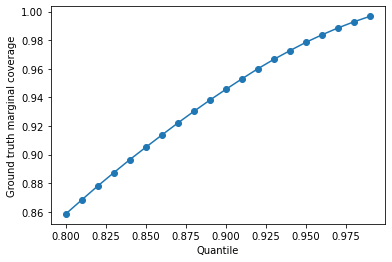

In [42]:
plt.plot(quantiles, marginal_cov, '-o')
plt.xlabel('Quantile')
plt.ylabel('Ground truth marginal coverage')
plt.show()

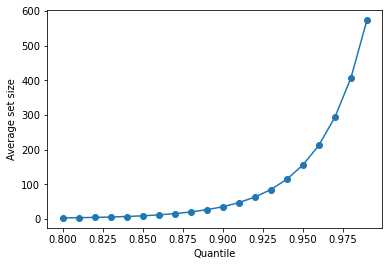

In [43]:
plt.plot(quantiles, avg_set_size, '-o')
plt.xlabel('Quantile')
plt.ylabel('Average set size')
plt.show()

# Section 2

Try using `deconvolveR` to get better estimate of prior. We compare to the oracle prior.

In [50]:
xmin, xmax = 0, 1.6
ymin, ymax = 0, 2

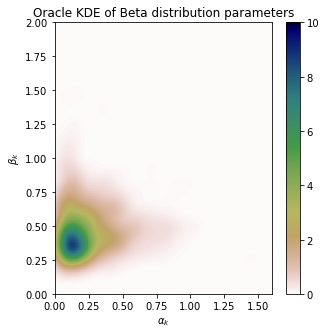

In [51]:
# Load in oracle prior
path = '.cache/kde.pkl'
with open(path, 'rb') as f:
    oracle = pickle.load(f)

# Visualize
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(oracle(positions).T, X.shape)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               vmin=0, vmax=10, 
               cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('Oracle KDE of Beta distribution parameters')
fig.colorbar(im)
plt.show()

In [65]:
# Load in deconvolved noisy priors
deconv_alphas = pd.read_csv('~/code/empirical-bayes-conformal/.cache/deconvolved_alphas.csv')
deconv_betas = pd.read_csv('~/code/empirical-bayes-conformal/.cache/deconvolved_betas.csv')

In [61]:
alphas_dict = []

,density
support_pts,
0.00,0.000265
0.04,0.000771
0.08,0.002188
0.12,0.005897
0.16,0.014717
...,...
3.84,0.000092
3.88,0.000095
3.92,0.000098


In [67]:
alphas, betas = np.meshgrid(deconv_alphas['density'], deconv_betas['density'])

In [71]:
product_density = alphas * betas

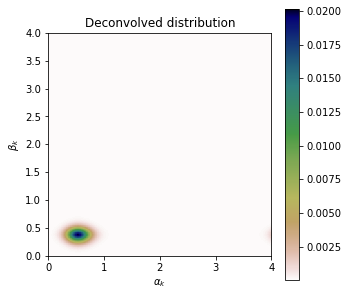

In [81]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(product_density), 
#                vmin=0, vmax=10, 
               cmap=plt.cm.gist_earth_r, extent=[0, 4, 0, 4])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('Deconvolved distribution')
fig.colorbar(im)
plt.show()

In [75]:
ax.imshow(np.rot90(product_density))
plt.show()

In [79]:
product_density.shape

(101, 101)

In [82]:
Z.sum()

2957.84179740363